What data to use for the classifier: Or in particular: Can we use the data used for lda training? It is unsupervised, so yes. We did look at the genres only for evaluation purposes, not as means of model selection. Only using a Kfold now would be a bit messy. Should have done model selection on every subset then. So will use cross validation for hyper parameter tuning again. SGD with modified huber loss worked well in https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28. Therefore use that. Here there is no big class imbalance, so do not need class_weight=balanced. Test different levels of regularization alpha

In [1]:
import gensim
import gensim.corpora as corpora
import os
import pandas as pd
import numpy as np
seed = 61

In [2]:
num_topics = 100
model_train = gensim.models.LdaModel.load('./results/lda_'+str(num_topics)+'.model')
df_train = pd.read_csv(os.path.join("results", "df_train"), encoding='utf-8').dropna()#why did some nan pop up?
df_test = pd.read_csv(os.path.join("results", "df_test"), encoding='utf-8').dropna()
corpus_train = corpora.MmCorpus(os.path.join("results", "corpus_train"))
corpus_test = corpora.MmCorpus(os.path.join("results", "corpus_test"))

In [3]:
#FIRST WITHOUT REMOVING VERBS
#GET FEATURE VECTORS
train_vecs = []
for i in range(len(df_train)):
    top_topics = model_train.get_document_topics(corpus_train[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    topic_vec.extend([len(df_train.iloc[i].lyric)]) #custom feature: length of lyric
    train_vecs.append(topic_vec)

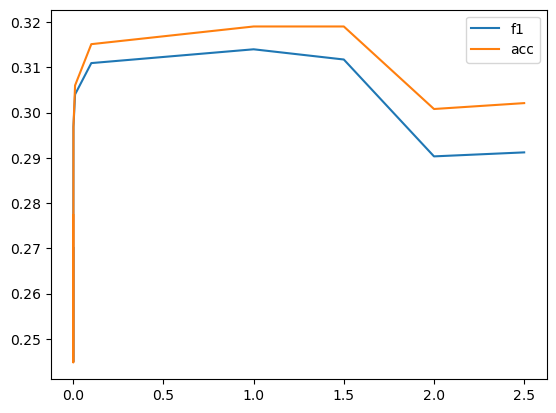

In [4]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#convert genre into categorical
categories = {'pop': 0, 'r-b':1, 'country':2, 'rock':3, 'rap':4}
df_train['genre_categorical'] = df_train.genre.apply(lambda x: categories[x])
df_test['genre_categorical'] = df_test.genre.apply(lambda x: categories[x])

X = np.array(train_vecs)
y = np.array(df_train.genre_categorical)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_train_scale, y_train)

    y_pred = sgd_huber.predict(X_val_scale)
    f1s.append(f1_score(y_val, y_pred, average='macro'))
    accs.append(accuracy_score(y_val, y_pred))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

Results: Best for alpha=0.01 with around 0.32 f1 score

Maybe better for less topics?

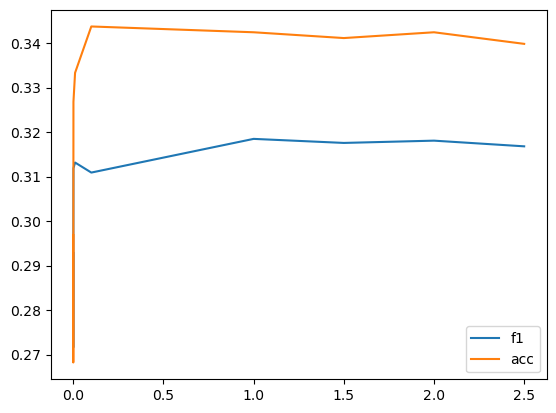

In [5]:
#TEST WHETHER BETTER RESULTS FOR LESS TOPICS
train_vecs_short = []
for i in range(len(df_train)):
    top_topics = model_train.get_document_topics(corpus_train[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(50)]
    topic_vec.extend([len(df_train.iloc[i].lyric)]) #custom feature: length of lyric
    train_vecs_short.append(topic_vec)

X_short = np.array(train_vecs_short)
X_short_train, X_short_val, y_short_train, y_short_val = train_test_split(X_short,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_short_train_scale = scaler.fit_transform(X_short_train)
X_short_val_scale = scaler.transform(X_short_val)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_short_train_scale, y_short_train)

    y_short_pred = sgd_huber.predict(X_short_val_scale)
    f1s.append(f1_score(y_short_val, y_short_pred, average='macro'))
    accs.append(accuracy_score(y_short_val, y_short_pred))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

Even worse results. Best f1 score around 0.31 (Accuracy not very good metric). take all 100 topics.

In [6]:
#try logistic regression as maybe better model
lr = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)
y_pred = lr.predict(X_val_scale)
print(f1_score(y_val, y_pred, average='macro'))
print(accuracy_score(y_val, y_pred))

0.304331157733439
0.3020833333333333


best result here: Take logistic regression

In [7]:
#GET PERFORMANCE ON TEST SET
#Get feature vectors 
test_vecs = []
for i in range(len(df_test)):
    top_topics = model_train.get_document_topics(corpus_test[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    topic_vec.extend([len(df_test.iloc[i].lyric)]) #custom feature: length of lyric
    test_vecs.append(topic_vec)
X_test = np.array(test_vecs)
y_test = np.array(df_test.genre_categorical)

#Scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X)#Remark: Now on full df_train
X_test_scale = scaler.transform(X_test)
y_train = y
#Train on full data and look at test error
lr_full = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

y_pred = lr_full.predict(X_test_scale)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

0.32402235402169277
0.3278837420526794


Aparrently model was overfitting (but why better to take more features), now with a little more data get better results: 0.38 f1-score

Thats not particularly good, but much better than random guess (1/5=0.2). But it shows that it is hard to separate topics between genres. Are there particular genres that are hard to classify?

In [8]:
#LOOK AT ACCURACY PER GENRE
for i in range(5):
    print("Genre: ", list(categories.keys())[list(categories.values()).index(i)])
    ind_genre = y_test == i
    y_genre_test = y_test[ind_genre]
    y_genre_pred = y_pred[ind_genre]
    print("percentage of data: ", len(y_genre_test)/len(y_test))
    print("acc score: ", accuracy_score(y_genre_test, y_genre_pred))
    

Genre:  pop
percentage of data:  0.18165304268846502
acc score:  0.225
Genre:  r-b
percentage of data:  0.21707538601271573
acc score:  0.21338912133891214
Genre:  country
percentage of data:  0.21707538601271573
acc score:  0.3807531380753138
Genre:  rock
percentage of data:  0.2061762034514078
acc score:  0.2422907488986784
Genre:  rap
percentage of data:  0.17801998183469572
acc score:  0.6071428571428571


So some genres are easier to classify, especially rap. On the other hand, rock and pop seem to be the hardest. This is not a problem of class imbalance.

Need an understanding of how hard it generally is to differentiate between genres from lyrics and whether these results are due to the topics.
But first: How is it when removing verbs as stop words

In [9]:
#NOW: WITH VERBS REMOVED
num_topics = 100
name = str(num_topics)+"_extended"
model_train_extended = gensim.models.LdaModel.load('./results/lda_'+name+'.model')
corpus_train_extended = corpora.MmCorpus(os.path.join("results", "corpus_train_extended"))
corpus_test_extended = corpora.MmCorpus(os.path.join("results", "corpus_test_extended"))

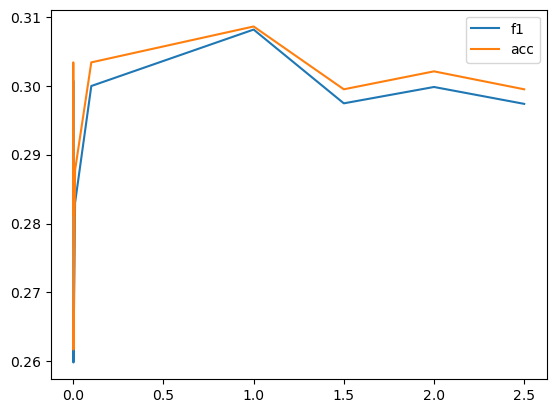

0.3170037278895847
0.3111979166666667


In [10]:
#GET DATA AND TRAIN SEVERAL MODELS TO CHOOSE FROM
train_vecs_extended = []
for i in range(len(df_train)):
    top_topics = model_train_extended.get_document_topics(corpus_train_extended[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    topic_vec.extend([len(df_train.iloc[i].lyric)]) #custom feature: length of lyric
    train_vecs_extended.append(topic_vec)

#convert genre into categorical
categories = {'pop': 0, 'r-b':1, 'country':2, 'rock':3, 'rap':4}
df_train['genre_categorical'] = df_train.genre.apply(lambda x: categories[x])
df_test['genre_categorical'] = df_test.genre.apply(lambda x: categories[x])
    
X_extended = np.array(train_vecs_extended)
y = np.array(df_train.genre_categorical)

X_train_extended, X_val_extended, y_train, y_val = train_test_split(X_extended,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_train_extended_scale = scaler.fit_transform(X_train_extended)
X_val_extended_scale = scaler.transform(X_val_extended)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_train_extended_scale, y_train)

    y_pred_extended = sgd_huber.predict(X_val_extended_scale)
    f1s.append(f1_score(y_val, y_pred_extended, average='macro'))
    accs.append(accuracy_score(y_val, y_pred_extended))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

#try logistic regression as maybe better model
lr = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_extended_scale, y_train)
y_pred = lr.predict(X_val_extended_scale)
print(f1_score(y_val, y_pred, average='macro'))
print(accuracy_score(y_val, y_pred))

Results: Again logistic Regression brings best results with an f1 score of ca. 0.33

In [11]:
#GET TEST PERFORMANCE
#get features
test_vecs_extended = []
for i in range(len(df_test)):
    top_topics = model_train_extended.get_document_topics(corpus_test_extended[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    topic_vec.extend([len(df_test.iloc[i].lyric)]) #custom feature: length of lyric
    test_vecs_extended.append(topic_vec)
X_test_extended = np.array(test_vecs_extended)
y_test = np.array(df_test.genre_categorical)

#Scale data
scaler = StandardScaler()
X_train_extended_scale = scaler.fit_transform(X_extended)
X_test_extended_scale = scaler.transform(X_test_extended)
y_train = y
#Train on full data and look at test error
lr_full = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_extended_scale, y_train)

y_pred = lr_full.predict(X_test_extended_scale)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

0.3115920337300725
0.3142597638510445


In [12]:
#LOOK AT ACCURACY PER GENRE
for i in range(5):
    print("Genre: ", list(categories.keys())[list(categories.values()).index(i)])
    ind_genre = y_test == i
    y_genre_test = y_test[ind_genre]
    y_genre_pred = y_pred[ind_genre]
    print("percentage of data: ", len(y_genre_test)/len(y_test))
    print("acc score: ", accuracy_score(y_genre_test, y_genre_pred))

Genre:  pop
percentage of data:  0.18165304268846502
acc score:  0.215
Genre:  r-b
percentage of data:  0.21707538601271573
acc score:  0.1799163179916318
Genre:  country
percentage of data:  0.21707538601271573
acc score:  0.3514644351464435
Genre:  rock
percentage of data:  0.2061762034514078
acc score:  0.2555066079295154
Genre:  rap
percentage of data:  0.17801998183469572
acc score:  0.6020408163265306


Results:
- Better performances when removing verbs
- Only really increases accuracy on r-b and country
- rock and pop still only as good as random guess